DC Resistivity: Inverting for Resistivities and Layers
======================================================

Here we use the module *SimPEG.electromangetics.static.resistivity* to invert
DC resistivity sounding data and recover the resistivities and layer thicknesses
for a 1D layered Earth. In this tutorial, we focus on the following:

- How to define sources and receivers from a survey file
- How to define the survey
- Defining a model that consists of resistivities and layer thicknesses

For this tutorial, we will invert sounding data collected over a layered Earth using
a Wenner array. The end product is layered Earth model which explains the data.
    

Import modules
--------------


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import (maps, data, data_misfit, regularization,
    optimization, inverse_problem, inversion, directives
    )
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.StaticUtils import plot_layer

Define Parameters for the Inversion
-----------------



In [2]:
# Define the file path to the data file. Also define the AB/2, MN/2 and apparent resistivity columns.
# Recall that python counts starting at 0
data_filename = './assets/Mawlamyaing_data_locations_3.txt'
half_AB_column = 0
half_MN_column = 1
apparent_resistivity_column = 6

# Define the floor and percent uncertainty you would like to apply to apparent resistivity data
uncertainty_floor = 5
uncertainty_percent = 5.

# Define layer thicknesses and resistivities for the starting model. The thickness
# of the bottom layer is not used, as we assume it extends downward to infinity.
# layer_thicknesses = np.r_[30, 30, 30, 30, 30, 200]
layer_thicknesses = np.r_[10, 10, 10, 10, 10, 10, 10, 200]


Load Data, Define Survey and Plot
---------------------------------

Here we load the observed data, define the DC survey geometry and plot the
data values.

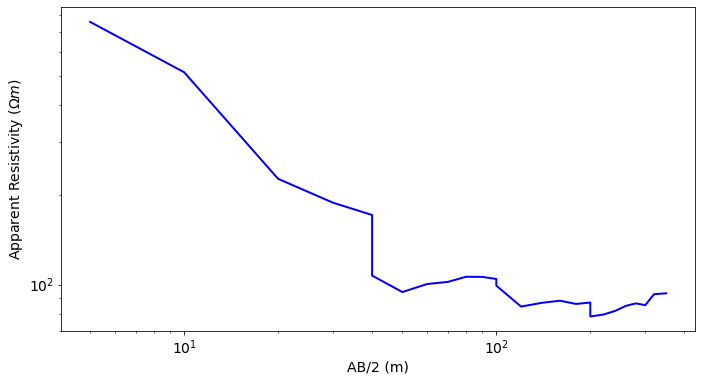

In [3]:
# Load data
dobs = np.loadtxt(str(data_filename), skiprows=1)

resistivities = np.ones(layer_thicknesses.size) * np.median(dobs)

# Extract source and receiver electrode locations and the observed data
half_AB_separations = dobs[:, half_AB_column]
half_MN_separations = dobs[:, half_MN_column]
dobs = dobs[:, apparent_resistivity_column]

# Define survey
unique_tx, k = np.unique(half_AB_separations, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(dobs)+1]

source_list = []
for ii in range(0, n_sources):
    
    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = -half_MN_separations[k[ii]:k[ii+1]]
    M_locations = np.c_[M_locations, np.zeros((np.shape(M_locations)[0], 2))]
    N_locations = half_MN_separations[k[ii]:k[ii+1]]
    N_locations = np.c_[N_locations, np.zeros((np.shape(N_locations)[0], 2))]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations)]
    
    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-half_AB_separations[k[ii]], 0, 0]
    B_location = np.r_[half_AB_separations[k[ii]], 0, 0]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

# Compute the A, B, M and N electrode locations.
survey.getABMN_locations()

# Plot apparent resistivities on sounding curve as a function of Wenner separation
# parameter.
electrode_separations = np.sqrt(
        np.sum((survey.m_locations - survey.n_locations)**2, axis=1)
        )

fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({'font.size': 14})
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separations, dobs, 'b', lw=2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
plt.show()

Assign Uncertainties
--------------------

Inversion with SimPEG requires that we define uncertainties on our data. The
uncertainty represents our estimate of the standard deviation of the noise on
our data.

In [4]:
uncertainties = uncertainty_floor + 0.01*uncertainty_percent*np.abs(dobs)

Define Data
--------------------

Here is where we define the data that are inverted. The data are defined by
the survey, the observation values and the uncertainties.

In [5]:
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

Defining the Starting Model and Mapping
---------------------------------------


In [6]:
# Define the layers as a mesh
mesh = TensorMesh([layer_thicknesses], '0')
print(mesh)

# Define model. We are inverting for the layer resistivities and layer thicknesses.
# Since the bottom layer extends to infinity, it is not a model parameter for
# which we need to invert. For a 3 layer model, there is a total of 5 parameters.
# For stability, our model is the log-resistivity and log-thickness.
starting_model = np.r_[np.log(resistivities), np.log(layer_thicknesses[:-1])]

# Since the model contains two different properties for each layer, we use
# wire maps to distinguish the properties.
wire_map = maps.Wires(('rho', mesh.nC), ('t', mesh.nC-1))
resistivity_map = maps.ExpMap(nP=mesh.nC) * wire_map.rho
layer_map = maps.ExpMap(nP=mesh.nC-1) * wire_map.t


  TensorMesh: 8 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      8          0.00        270.00     10.00    200.00   20.00




In [7]:
mesh.nC

8

Define the Physics
------------------

Here we define the physics of the problem using the DCSimulation_1D class.


In [8]:
simulation = dc.simulation_1d.DCSimulation_1D(
        mesh, survey=survey, rhoMap=resistivity_map, tMap=layer_map,
        data_type="apparent_resistivity"
        )

Define Inverse Problem
----------------------

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem



In [9]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

# Define the regularization on the parameters related to resistivity
mesh_rho = TensorMesh([mesh.hx.size])
reg_rho = regularization.Simple(
    mesh_rho, alpha_s=1., alpha_x=1,
    mapping=wire_map.rho
)

# Define the regularization on the parameters related to layer thickness
mesh_t = TensorMesh([mesh.hx.size-1])
reg_t = regularization.Simple(
    mesh_t, alpha_s=1., alpha_x=1,
    mapping=wire_map.t    
)

# Combine to make regularization for the inversion problem
reg = reg_rho + reg_t

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterCG=30
)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

Define Inversion Directives
---------------------------

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.



In [10]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1.)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=1.)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined in a list
directives_list = [
        starting_beta, beta_schedule, target_misfit
        ]

# directives_list = [
#         target_misfit
# ]
# inv_prob.beta = 0.

Running the Inversion
---------------------

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [11]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.04e+01  5.38e+02  0.00e+00  5.38e+02    2.54e+02      0              
   1  3.52e+01  2.13e+02  1.17e+00  2.54e+02    1.34e+02      0              
   2  1.76e+01  7.68e+01  2.63e+00  1.23e+02    1.29e+02      0              
   3  8.80e+00  4.01e+01  3.38e+00  6.98e+01    6.14e+01      0              
   4  4.40e+00  2.19e+01  4.24e+00  4.05e+01    2.76e+01      0   Skip BFGS  
   5  2.20e+00  1.78e+01  4.71e+00  2.81e+01    1.06e+01      0   Skip BFGS  
   6  1.10e+

In [12]:
layer_map*recovered_model

array([ 4.39555566, 13.32682117, 10.13809207, 17.64415063, 10.99937004,
       11.61952875, 13.74039202])

In [13]:
res_tmp = np.array([348.4, 722.9, 282, 100.8, 51.4, 170.8, 31.1, 184.3])
thick_tmp = np.array([1.4, 1.6, 1.4, 12.1, 11.4, 25.1, 54.2])
plotting_mesh_tmp = TensorMesh([np.r_[thick_tmp, layer_thicknesses[-1]]], '0')

Examining the Results
---------------------



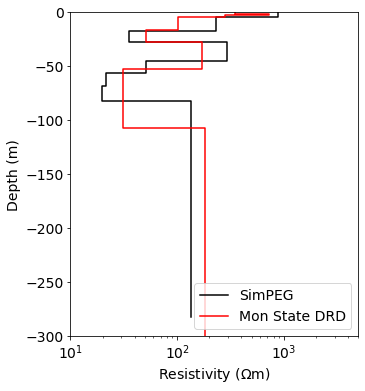

In [14]:
# Plot true model and recovered model
fig = plt.figure(figsize=(5, 5))
mpl.rcParams.update({'font.size': 14})
plotting_mesh = TensorMesh([np.r_[layer_map*recovered_model, layer_thicknesses[-1]]], '0')
x_min = np.min(resistivity_map*recovered_model)
x_max = np.max(resistivity_map*recovered_model)

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_layer(resistivity_map*recovered_model, plotting_mesh, ax=ax1, depth_axis=False, color='k')
plot_layer(res_tmp, plotting_mesh_tmp, ax=ax1, depth_axis=False, color='r')
# ax1.set_xlim(0.9*x_min, 1.1*x_max)
ax1.set_xlim(10, 5000)
ax1.set_ylim(-300, 0)
ax1.legend(("SimPEG", "Mon State DRD"))

(-300, 0)

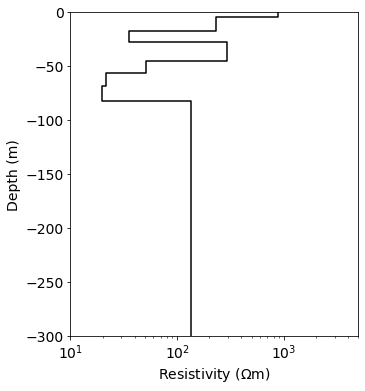

In [18]:
# Plot true model and recovered model
fig = plt.figure(figsize=(5, 5))
mpl.rcParams.update({'font.size': 14})
plotting_mesh = TensorMesh([np.r_[layer_map*recovered_model, layer_thicknesses[-1]+100]], '0')
x_min = np.min(resistivity_map*recovered_model)
x_max = np.max(resistivity_map*recovered_model)

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_layer(resistivity_map*recovered_model, plotting_mesh, ax=ax1, depth_axis=False, color='k')
# plot_layer(res_tmp, plotting_mesh_tmp, ax=ax1, depth_axis=False, color='r')
# ax1.set_xlim(0.9*x_min, 1.1*x_max)
ax1.set_xlim(10, 5000)
ax1.set_ylim(-300, 0)
# ax1.legend(("SimPEG", "Mon State DRD"))

In [15]:
layer_map*recovered_model

array([ 4.39555566, 13.32682117, 10.13809207, 17.64415063, 10.99937004,
       11.61952875, 13.74039202])

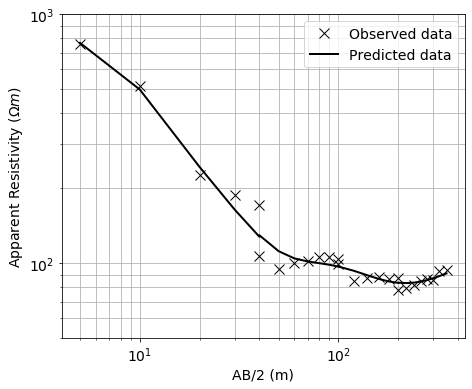

In [16]:
###### Plot the true and apparent resistivities on a sounding curve
from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(7, 5))
mpl.rcParams.update({'font.size': 14})
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separations, dobs, 'kx', lw=2, ms=10)
ax1.loglog(half_AB_separations, inv_prob.dpred, 'k', lw=2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
ax1.legend(['Observed data','Predicted data'])
# ax1.set_yticks([100, 200, 300, 400, 500, 600, 700, 800])
# ax1.set_yticklabels([str(ii) for ii in [100, 200, 300, 400, 500, 600, 700, 800]])
ax1.set_ylim(50, 1000)
ax1.grid(True, which='both')
plt.show()